## Content

1. Introduction
2. Understanding our spam classifier data

3. Mathematical intuition
 - Calculating class priors
4. Naive assumption
 - Calculating likelihoods
 - Final equation

5. Train time of Naive Bayes

6. Test time of Naive Bayes

7. Complexity of Naive Bayes



## **Imagine you are Data Scientist at Google**

You are working on **Spam Classification model**

#### (Interaction) Question: What do you think will be good for classifying spam from not spam mails? 

We can say that that email content will be one of the useful things in classfying the email.

Now, let's focus on the email text. 

#### Q. Which one one of the following do you think is a spam? 

1. Mail 1 : "I, Nigerian prince need your help. Send money"
2. Mail 2: "Meeting scheduled for 5 pm. Kindly revert"


Obviously, Mail 1 is a spam mail.

<br>

#### Q. How did you come to conclusion that Mail 1 is Spam mail ? 

Notice that there are few keywords which are specific to Spam mail only.

- For example: 
"Nigerian prince", "lottery", "million dollars" all points to that mail is more likely to be spam.

<br>


#### Q. What if we had basic approach that classifies spam from ham based on all these **keywords**?


Let's look at a technique which works on the same principles i.e. Naive Bayes.










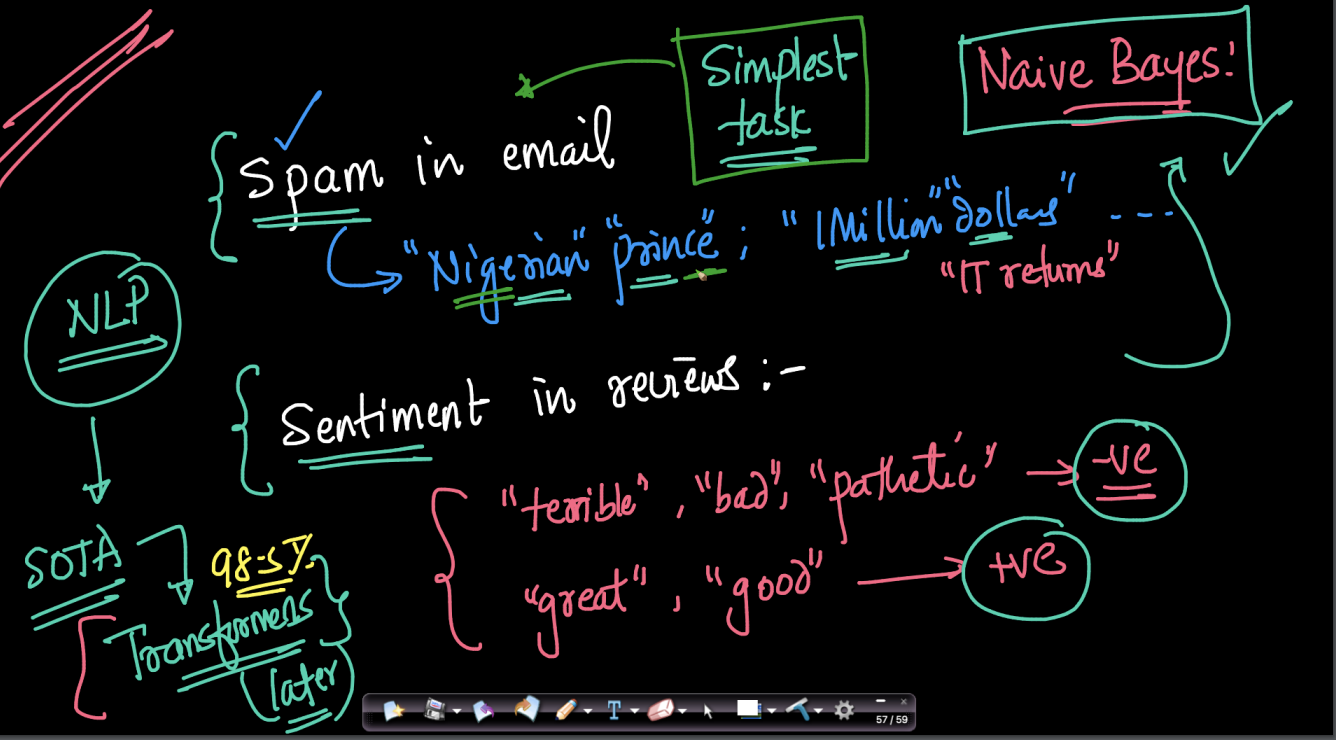

#### Understanding our spam classifier data

#### Q. What do we have in our data? 

For our data, we have  
1. n number of texts which contains words
2. class label i.e. 
    - Spam will be (class 1 or y = 1)
    - Ham (or Not spam) will be (class 0 or y = 0)

## **Q. What do we understand by text?**

The text body of email is essentially a **sequence of words**. 

We can write $text_i$, as $ text_{i} = w_{1}^i, w_{2}^i, w_{3}^i, ..., w_{d}^i $ 


where, d -> length of text $email_i$.

**Note:** The number of words in text1 **may or may not be equal** to the number of words in text2


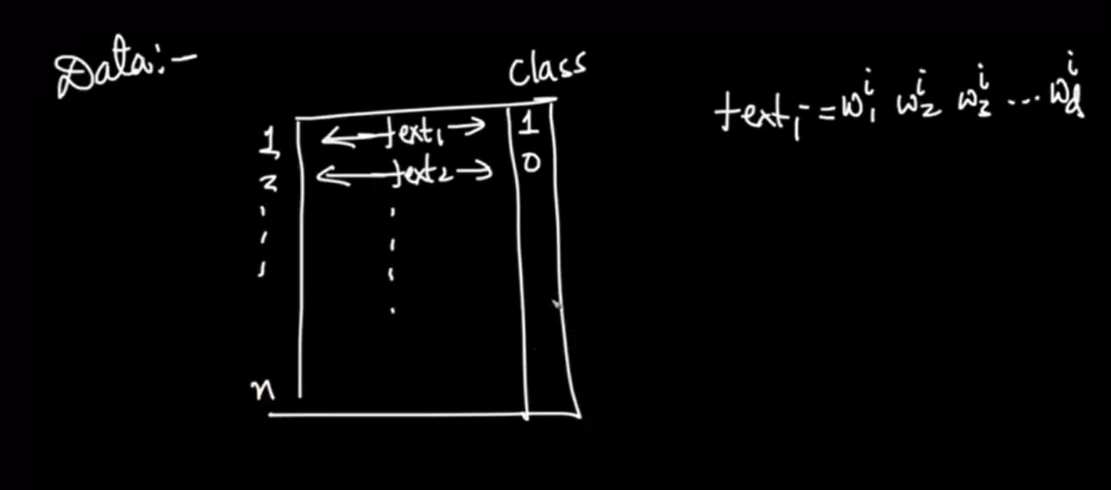

Let's look at our data now

In [ ]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Let's load the data

In [ ]:
!gdown 1d4VFxFxPqBpKoUuH51PQ8PYrFBmPCnH8

Downloading...
From: https://drive.google.com/uc?id=1d4VFxFxPqBpKoUuH51PQ8PYrFBmPCnH8
To: /content/spam_clean.csv
100% 484k/484k [00:00<00:00, 133MB/s]


#### Q. How do we make sure that the system knows our data is in English?
- We can set the value of parameter **encoding** as `latin-1` to  explicitly mention that the letters in the texts are english.

In [ ]:
df = pd.read_csv('spam_clean.csv', encoding='latin-1')
df.head()

type                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

#### Performing EDA

Let's see the distribution of class labels


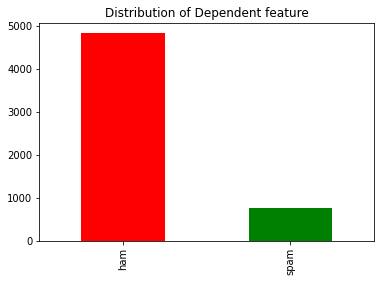

In [ ]:
freq = pd.value_counts(df["type"], sort= True)
freq.plot(kind= 'bar', color= ["red", "green"])
plt.title('Distribution of Dependent feature')
plt.show()

**Observation**:

As we can see, the number of texts which are spam are quite less as compared to the texts which are ham (or not spam)

Clearly, we have an **imbalanced data**!


# **Preprocessing data**

####1. Tokenization

Let's first split the sentence into it's constituent words (i.e. individual **tokens**)

This is also known as **tokenization**

<br>


Lets take an example to understand this:

Sentence:  **"Hi my name is Anthony Gonsalves."**

After splitting the sentence, we get

List: ["my", 'Hi", "is", "Gonsalves", "Anthony", "name", "."]




### 2. Lower Casing

#### Q. Given two setences, Should they be treated as different or same? 

Sentence 1 : Let's go to the mall

Sentence 2: let's GO to the MALL

Ans: **No!**. We don't want to treat these **intances/ sentences** as different one.

<br>


#### Q. How do we resolve this?

One way to avoid multiple instances of same word/sentence is to **convert them to lower case**.







#### 3. Removing punctuations

```
Mail 1 : "I, Nigerian price need your help. Send money"

Mail 2: "Meeting scheduled for 5 pm. Kindly revert"
```

In order to differentiate between spam v.s ham,
- we focused on **keywords** which helped us in differentiating.

<br>

#### Q. Do we need to look at punctuations while classfying mails? 

Ans: No. As our focus is keyword which can help us classify.

Hence, we will be removing these using the **Regular Expressions**.


#### 4. Stop Words

#### Q. Do you think words like a, an, the, of are useful in classifying spam from ham ? 

These words (a, an, the, do, it, she, it etc) are called **stop words**
- These are some of the most common, short function words and
- They add little or no **real meaning** to our text as  they carry **very little** useful information.

So, They can **safely be ignored without sacrificing the meaning of the sentence**. 

Not to mention, parsing through these words would make it more **computationally expensive** for no reason.

We remove these words from our data.


Do NOTE: But there are tasks like translation, Que-Ans based system  where we cannot remove stop words.



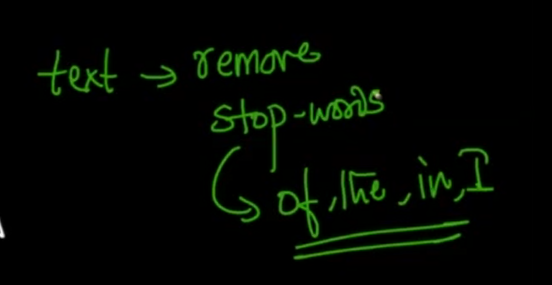

#### Q. Wouldn't removing stop words lead to grammatical errors?
**Yes**. It will. 

But since to understand context from keywords, grammer is not important hence we use stopwords removal technique

Lets implement all of these text processing using the  [NLTK](https://www.nltk.org/) library 

In [ ]:
# Libraries for text processing
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

def clean_tokenized_sentence(s):
    """Performs basic cleaning of a tokenized sentence"""
    cleaned_s = ""  # Create empty string to store processed sentence.
    words = nltk.word_tokenize(s)
    for word in words:
        # Convert to lowercase #
        c_word = word.lower()
        # Remove punctuations #
        c_word = re.sub(r'[^\w\s]', '', c_word)
        # Remove stopwords #
        if c_word != '' and c_word not in stopwords.words('english'):
            cleaned_s = cleaned_s + " " + c_word    # Append processed words to new list.
    return(cleaned_s.strip())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Calling the `clean_tokenized_sentence(s)` function onto each text in our dataset using the **apply** method, and storing them in a new column, `cleaned_message`

In [ ]:
df["cleaned_message"] = df["message"].apply(clean_tokenized_sentence)
df.head(10)

type                                            message  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   
5  spam  FreeMsg Hey there darling it's been 3 week's n...   
6   ham  Even my brother is not like to speak with me. ...   
7   ham  As per your request 'Melle Melle (Oru Minnamin...   
8  spam  WINNER!! As a valued network customer you have...   
9  spam  Had your mobile 11 months or more? U R entitle...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4          nah nt think goes usf lives around though  
5  freemsg hey darling 3 week word back like fun ...  
6     even brother like speak treat like aids patent  
7  per request melle melle oru minnaminunginte nu...  
8  winner valued network customer selected receiv...  
9  mobile 11 months u r entitled update latest co...



## Q. Do some words tend to occur more frequently in ham texts than in spam texts?
Yes. Recall we talked about some keywords being specific to spam or ham messages.

Words like "Nigerian prince", "lottery", "prize", etc tend to occur more in spam messages than in ham.

<br>

#### Q. How can we look at the Word frequencies (number of times each word occurs) in a given text?

In order to get the frequency of occurrence of the words in a given text, we employ the use of `Counter` from the `collections` library.

The **Counter()** counts the number of time each word occurs after splitting.


<br>

#### Lets see the most occuring words in ham messages
#### Q. How do we get the top 20 words that occur the most frequently in ham texts?

We need to first filter the non-spam rows,
- then Obtain the cleaned message
- followed by Splitting the messages into words
- and finally Invoking the Counter() object

 First, let's filter the texts that are of type = 'ham'



In [ ]:

ham = df[df['type'] == 'ham']
ham

type                                            message  \
0     ham  Go until jurong point, crazy.. Available only ...   
1     ham                      Ok lar... Joking wif u oni...   
3     ham  U dun say so early hor... U c already then say...   
4     ham  Nah I don't think he goes to usf, he lives aro...   
6     ham  Even my brother is not like to speak with me. ...   
...   ...                                                ...   
5565  ham                                       Huh y lei...   
5568  ham              Will Ì_ b going to esplanade fr home?   
5569  ham  Pity, * was in mood for that. So...any other s...   
5570  ham  The guy did some bitching but I acted like i'd...   
5571  ham                         Rofl. Its true to its name   

                                        cleaned_message  
0     go jurong point crazy available bugis n great ...  
1                               ok lar joking wif u oni  
3                   u dun say early hor u c already say  
4             nah nt think goes usf lives around though  
6        even brother like speak treat like aids patent  
...                                                 ...  
5565                                            huh lei  
5568                       ì_ b going esplanade fr home  
5569                              pity mood suggestions  
5570  guy bitching acted like interested buying some...  
5571                                     rofl true name  

[4825 rows x 3 columns]

Since we only wish to look at our preprocessed text, we get the cleaned_message column

In [ ]:
ham = ham['cleaned_message']
ham

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
3                     u dun say early hor u c already say
4               nah nt think goes usf lives around though
6          even brother like speak treat like aids patent
                              ...                        
5565                                              huh lei
5568                         ì_ b going esplanade fr home
5569                                pity mood suggestions
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: cleaned_message, Length: 4825, dtype: object

We club all the texts for Ham 

In [ ]:

ham = " ".join(ham)
ham

'go jurong point crazy available bugis n great world la e buffet cine got amore wat ok lar joking wif u oni u dun say early hor u c already say nah nt think goes usf lives around though even brother like speak treat like aids patent per request melle melle oru minnaminunginte nurungu vettam set callertune callers press 9 copy friends callertune gon na home soon nt want talk stuff anymore tonight k cried enough today searching right words thank breather promise wont take help granted fulfil promise wonderful blessing times date sunday oh k watching eh u remember 2 spell name yes v naughty make v wet fine thatåõs way u feel thatåõs way gota b seriously spell name iûm going try 2 months ha ha joking ì_ pay first lar da stock comin aft finish lunch go str lor ard 3 smth lor u finish ur lunch already ffffffffff alright way meet sooner forced eat slice really hungry tho sucks mark getting worried knows sick turn pizza lol lol always convincing catch bus frying egg make tea eating mom left di

Now Splitting the entire text into words 

In [ ]:

ham = ham.split()
ham

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat',
 'ok',
 'lar',
 'joking',
 'wif',
 'u',
 'oni',
 'u',
 'dun',
 'say',
 'early',
 'hor',
 'u',
 'c',
 'already',
 'say',
 'nah',
 'nt',
 'think',
 'goes',
 'usf',
 'lives',
 'around',
 'though',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aids',
 'patent',
 'per',
 'request',
 'melle',
 'melle',
 'oru',
 'minnaminunginte',
 'nurungu',
 'vettam',
 'set',
 'callertune',
 'callers',
 'press',
 '9',
 'copy',
 'friends',
 'callertune',
 'gon',
 'na',
 'home',
 'soon',
 'nt',
 'want',
 'talk',
 'stuff',
 'anymore',
 'tonight',
 'k',
 'cried',
 'enough',
 'today',
 'searching',
 'right',
 'words',
 'thank',
 'breather',
 'promise',
 'wont',
 'take',
 'help',
 'granted',
 'fulfil',
 'promise',
 'wonderful',
 'blessing',
 'times',
 'date',
 'sunday',
 'oh',
 'k',
 'watching',
 'eh',
 'u',
 'remember',
 '2',
 'spell',
 'name',
 'yes',


Finding the top 20 words mostly used in Ham

In [ ]:
counter_ham = Counter(ham).most_common(20)
counter_ham

[('u', 1004),
 ('nt', 360),
 ('gt', 318),
 ('lt', 316),
 ('2', 309),
 ('get', 303),
 ('ok', 279),
 ('go', 248),
 ('got', 244),
 ('ur', 241),
 ('know', 236),
 ('like', 231),
 ('call', 231),
 ('good', 229),
 ('come', 227),
 ('time', 197),
 ('day', 192),
 ('love', 191),
 ('4', 172),
 ('going', 169)]

**Note:** Counter() object returns a **dictionary**, with word as the key, and it's count as the respective value. 

But when we call the `most_common()` method, it transforms the dictonary to  a tuple and returns a list of tuples as the result.

Alternatively, we could've clubbed these steps into one line as

In [ ]:
# counter_ham = Counter(" ".join(df[df['type']=='ham']["cleaned_message"]).split()).most_common(20)

Visualizing the 20 words and there number of Occurence

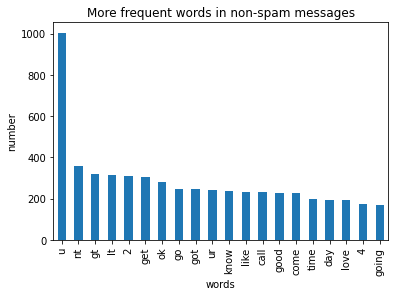

In [ ]:
# load the results as a pandas dataframe in order to plot
df_ham = pd.DataFrame(counter_ham)

# Renaming the columns in this dataframe
df_ham = df_ham.rename(columns={0:"words in non-spam", 1:"count"})

# Plotting the data
df_ham.plot.bar(legend = False)
y_pos = np.arange(len(df_ham["words in non-spam"]))
plt.xticks(y_pos, df_ham["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see words like "love", "time", "got", "go", etc tend to occur a lot in ham messages.

Similarily, we plot the data for 20 most common words in spam texts.

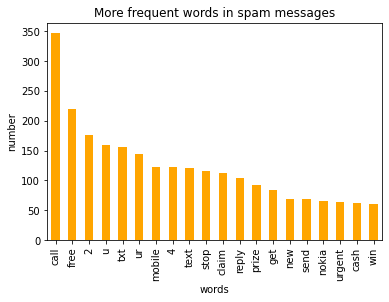

In [ ]:
# Invoking the Counter() object on a list of words occuring in the "cleaned_message" column of spam texts, joined together
counter_spam = Counter(" ".join(df[df['type']=='spam']["cleaned_message"]).split()).most_common(20)

# load the results as a pandas dataframe in order to plot
df_spam = pd.DataFrame(counter_spam)

# Renaming the columns in this dataframe
df_spam = df_spam.rename(columns={0:"words in spam", 1:"count_"})

# Plotting the data
df_spam.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df_spam["words in spam"]))
plt.xticks(y_pos, df_spam["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that there is a difference of words contained in spam and ham messages.

Spam messages have words like, "call", "free", "mobile", "claim", "prize", etc.


Converting the categorical feature `type` into a numerical feature by mapping spam value as 1, and ham values as 0.

In [ ]:
df["type"] = df["type"].map({'spam':1,'ham':0})

Performing the `train_test_split`

In [ ]:
from sklearn.model_selection import train_test_split

df_X_train, df_X_test, y_train, y_test = train_test_split(df['cleaned_message'], df['type'], test_size=0.25, random_state=42)
print([np.shape(df_X_train), np.shape(df_X_test)])

[(4179,), (1393,)]


# **Mathematical Intuition**



#### Q. How do we go about predicting whether a given $text_i$, is spam (y=1) or not (y=0)?

In order to do so, we calculate two probability values 
1. Probabilty that given text is spam $ P(y=1|text)$
2. Probabilty that given text is ham $P(y=0|text) $

Out of the two Probabilities, Whichever value we find to be **higher**, we get our answer accordingly.

<br>

#### Q. How can we find the value of $P(y=1|text)$ and $P(y=0|text)$?
Recall how text is just some sequence of d words

Hence we can say, 
- "Probability that text i is a spam given that words $w_{1}^i$ **AND** $w_{2}^i$ **AND** $w_{3}^i$ **AND**  ... **AND** $w_{d}^i$ exist in our text".

 - Therefore $ P_{i}(y=1|text_{i})$ can be written as $ P_{i}(y=1|w_{1}^i, w_{2}^i, w_{3}^i, ..., w_{d}^i) $ <br>
 - Similarly, $ P_{i}(y=0|text_{i})$ can be written as $ P_{i}(y=0|w_{1}^i, w_{2}^i, w_{3}^i, ..., w_{d}^i) $ <br>





#### Q. How can we find the value of $ P_{i}(y=1|w_{1}^i, w_{2}^i, w_{3}^i, ..., w_{d}^i) $?

Since this is **conditional probability**, perhaps we can apply **Baye's theorm**?

> Recall Baye's theorm from Probability/Stats lecture: **[PREREAD]**<br>
- if A and B are some events then 
$P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$<br>
where, <br>
P(A|B)	=	probability of A given B is true<br>
P(B|A)	=	probability of B given A is true<br>
P(A), P(B)	=	the independent probabilities of A and B

<br>

Now Assuming X be the event that words $w_{1}^i, w_{2}^i, w_{3}^i, ..., w_{d}^i$ exist in our text.

This means $ P_{i}(y=1|w_{1}^i, w_{2}^i, w_{3}^i, ..., w_{d}^i) = P_{i}(y=1|X)$ 

<br>

- According to Baye's theorm, we have, <br>
$P_{i}(y=1|X) = \frac{P(X|y=1)*P(y=1)}{P(X)} $

Let k = P(X) <br>

- $P_{i}(y=1|X) = \frac{P(X|y=1)*P(y=1)}{k}$

- Similarily, we get equation for P(y=0|X) as:- <br>
$P_{i}(y=0|X) = \frac{P(X|y=0)*P(y=0)}{P(X)} = \frac{P(X|y=0)*P(y=0)}{k}$

<br>

#### Q. What do we do after calculating the values of $P_{i}(y=1|X)$ and $P_{i}(y=0|X)$?

As we discussed earlier, we **compare the values** of $P_{i}(y=1|X)$ and $P_{i}(y=0|X)$. 

- Since, $P(X) = P(w_1^i, w_2^i, ..., w_d^i) = k$ will be a constant in both cases, we can **remove it** while comparing.

<br>


Thus we are left with $P_{i}(y=1|X) = P(X|y=1)*P(y=1)$ and $P_{i}(y=0|X) = P(X|y=0)*P(y=0)$ 
- now, if we find the values of these 4 terms of probabilities we're done.


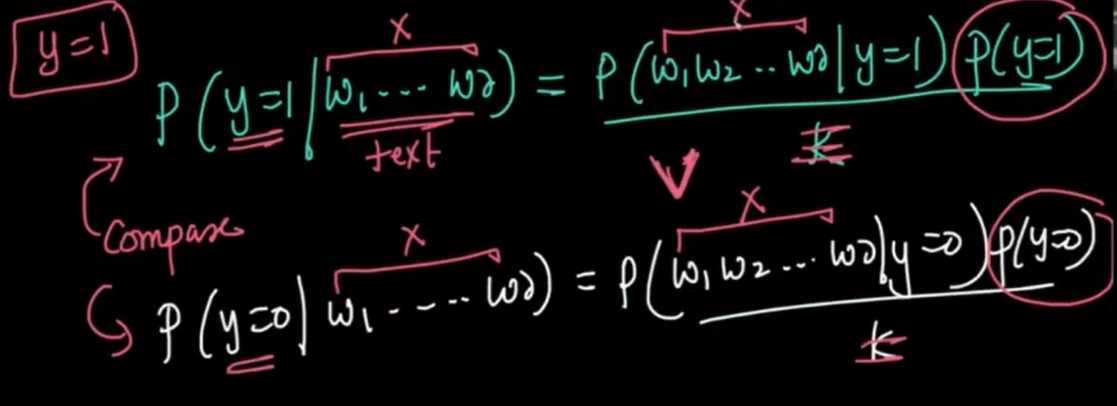

# Q. How can we get the values of P(y=1) and P(y=0)?

In our training data, our dependent variable $y_i$ has two values 1 and 0

- Hence, in order to calculate $P(y=1)$, 
 - we **find the number of train points where occcurence of y=1** 
 - and divide it by the **total number of train points** 


Similarily, we can calculate $P(y=0)$ 
- by dividing **the number of train points where occcurence of y=0** 
- to the **total number of train points** to get the probability for y=0.

<br>

**Note:** These $P(y=0)$ and $P(y=1)$ are called as the **class priors**.



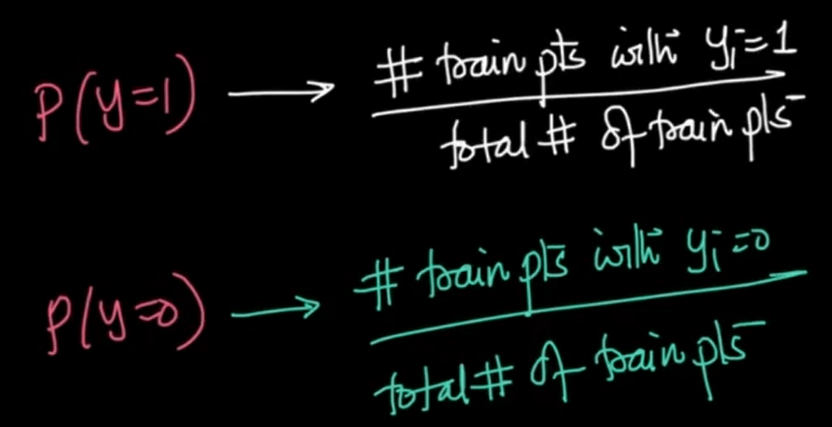

# **Naive Assumption**



#### Q. What about 𝑃(𝑋|𝑦=1) and 𝑃(𝑋|𝑦=0)?
Lets first understand for $𝑃(𝑋|𝑦=1)$

It means that 
- "given that the email is spam (y=1) 
- then what is the probability that the email contains the words $w_{1}^i$ **and** $w_{2}^i$ **and** $w_{3}^i$ **and** ... **and** $w_{d}^i$ 



<br>

#### Q. What problems can it cause for computing the probability of a text containing $𝑤^𝑖_1$ and $𝑤^𝑖_2$ and $𝑤^𝑖_3$ and ... and $𝑤^𝑖_𝑑$ being spam ($P(X|y=1)$)?

From the entire training dataset, first, we have to select the y = 1 samples
- Then, we had to choose only those samples which have **all of the d words**
- This number of occurence of all the words in text can be **small**
- Hence causing selection of only a handful of samples in the data.

Hence P(X|y=1) would be a **very small value** which can have **no signficant purpose**.

Not to mention, this will be **computationally expensive**!




## Q. What can we do to make P(X|y=1) a more sensible value?

Lets make a very simplified (naive) assumption that "the events of occurence of words $w_{1}^i, w_{2}^i, w_{3}^i, ..., w_{d}^i$ is **independant** of each other, but **conditioned on the class** (i.e. whether y=1 or y=0)".

Lets take an example to understand this
 - Suppose we have only two words "Nigerian" and "prince" when y = 1
 - Then, as per the naive assumption, we can say P("Nigerian prince" | y=1) = P("Nigerian"|y=1). P("prince"|y=1)

<br>

#### Q. Why is this assumption naive?
The Assumption is naive since, it may not always be true, but its a reasonable assumption to make. 

The words are not independent of each other every time. 

For example, Nigerian and Prince are not actually independent of each other, they generally exist together.

<br>

**Note:** From interview standpoint, a mistake that people make is that, they forget that in our naive assumption, this independance of occurence of words, is **"conditioned on the class"**. It is not the marginial probability that is independant, rather it is the **conditional probability** that is independant.


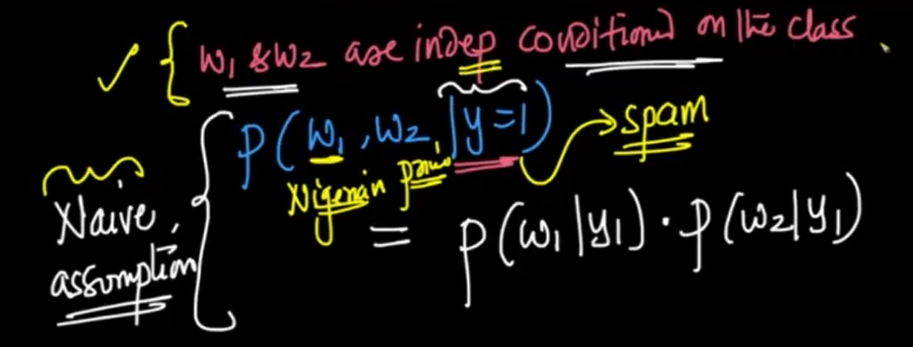

Since now the words are indpendent of each other on the condition that y=1, we can say:

- $P(w_1. w_2, w_3, ..., w_d|y=1) = P(w_1|y=1)*P(w_2|y=1)*...*P(w_d|y=1)$

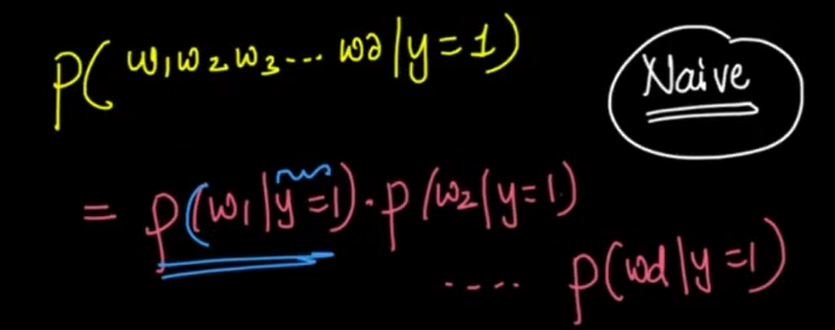

## Q. How can we find $P(w_{1}|y=1)$ ? 
Since $P(w_{1}|y=1)$ means the probability of having the word $w_1$ in our text, given that the text is spam (y=1)

- We go through all the texts that are spam (where y=1). Let the total number of texts that are spam in the dataset be n<sub>1</sub>  
- Find the number of texts where the word **w<sub>1</sub> exists**. Let the number of texts where we find this word be $n_{1}'$

So, $P(w_{1}|y=1)$ becomes $P(w_{1}|y=1) = \frac{n_{1}'}{n_{1}} $

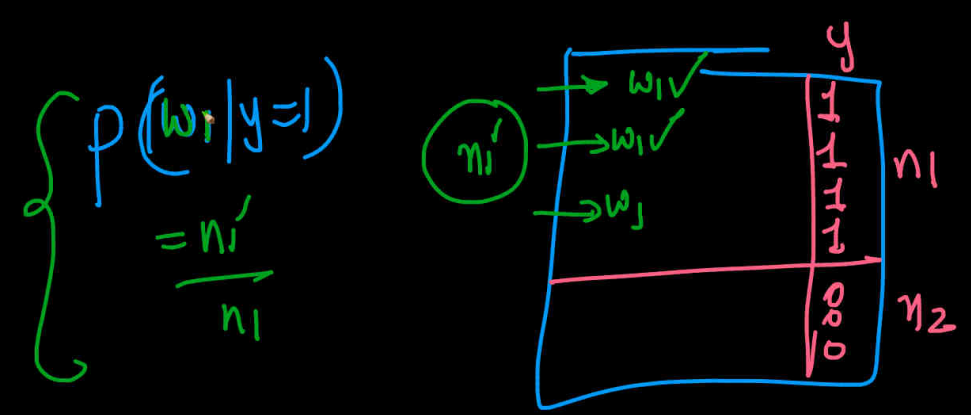

We had already seen how to calculate the terms $P(y=1)$ and $P(y=0)$

We just saw how to calculate the value for $P(w_1, w_2, ..., w_d|y=1)$ and $P(w_1, w_2, ..., w_d|y=0)$ using our **naive assumption**

<br>

So, putting these both together, we can write $P(y=1|text)$  as:- 

$P(y=1|text) = \frac{P(y=1) * P(w_1|y=1) * P(w_2|y=1) * P(w_3|y=1) * ... * P(w_d|y=1)}{k}$

<br>

We can simplify this by using the $Π$ notation for multiplication as:

 $P(y=1|text) = \frac{P(y=1) * Π_{i=1}^d P(w_i|y=1)}{k}$

<br>

Similarily, we can get the expression for $P(y=0|text)$ also as:-

$P(y=0|text) = \frac{P(y=0) * Π_{i=1}^d P(w_i|y=0)}{k}$




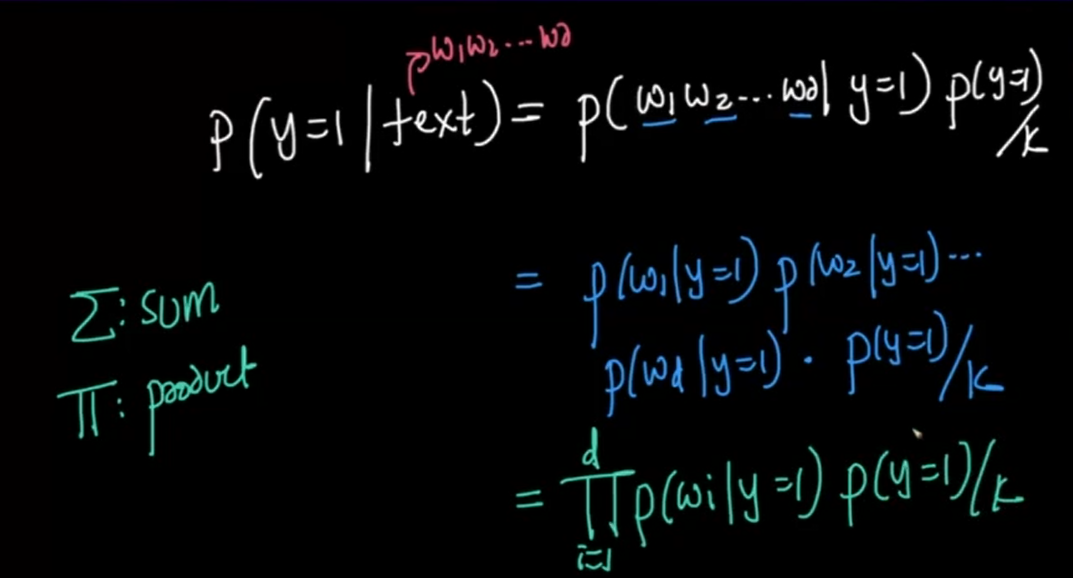


## Q. How can we make the final prediction of whether a text is spam or not ?

By simply comparing $P(y=1|text)$ and $P(y=0|text)$, and which ever one is higher becomes our final prediction

Recall that we simply cancel out the constant $k = P(𝑤_𝑖^1,𝑤_𝑖^2,𝑤_𝑖^3,...,𝑤_𝑖^𝑑)$ from both the equations, since the constant is same in both $P(y=1|text)$ and $P(y=0|text)$

<br>

**Note:** 
- The terms $P(y=1)$ and $P(y=0)$ are called **class priors**. 

 - It is simply the probability that a data point belongs to class 0 or 1.

- While The terms $P(w_{i}|y=1)$ and $P(w_{i}|y=0)$ are called **likelihoods**. 
 - Likelihood is the probability of occurence of each word, conditioned on the class.

- hence we can write:
 - P(y=1|text) = (class prior)*(product of likelihoods)

<br>

We used a Naive assumption along with Baye's theorm, hence we get the name Naive Bayes for this algorithm!




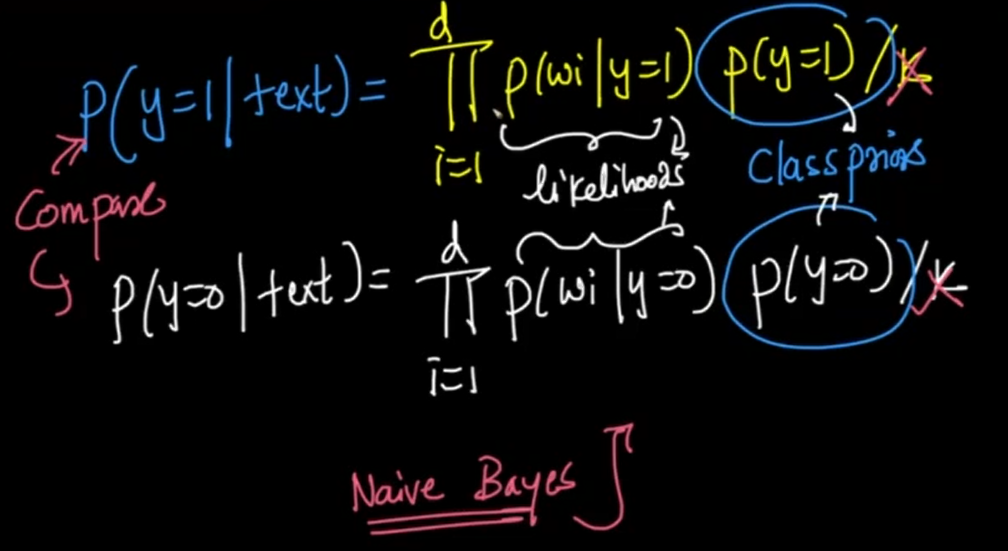


# **Q. Why Naive Bayes?**
If our task is a simple classification task with natural language text, Naive Bayes is a very popular model. This is so because:-
- **Simple**
 - As opposed to state of the art technology for NLP, **transformers** 
 - Transformers are crazy complex
 - Just making sure they are working fine is a big challenge.
- **Super Fast**
- **Works really well for simple NLP tasks**
 - Fetches about 80-90% accuracy, whereas state of the art methods would fetchs about 98.5% or so accuracy.
- **Interpretable**
 - A smart and interpretable model that works really well for simlpe tasks.


---
---
---

## **Train time of Naive Bayes**

#### Q. We have seen the mathematical intuition of Naive Bayes, but what exactly happens during training and testing?

Lets look into how training of Naive Bayes is done

First lets look on how our training dataset looks like:

<br>

#### Q. What will be features for Naive Bayes model ?
All the **unique words** present in all the texts of our dataset.

These set of all unique words in the dataset becomes Corpus for our data

Now lets assume we have w1,w2,w3.....wd unique words

- All the samples of the dataset becomes our text_i or $x_i$
- And for each sample we have a corresponding $y_i$ label

<br>

#### Q. What do we need to calculate during testing in NB?
Recall that for finding $P(y=1| w1,w2...wd)$ we basically need to find two things:
- Class Priors
    - P(y=1)
    - P(y=0)
- Likelihoods
    - $P(w_{j}|y_{i}=1)$
    - $P(w_{j}|y_{i}=0)$

<br>


#### Q. How will we calculate class priors for train dataset ?
- we first find the number of samples where $y_i=1$ and divide it with the total number of samples  in our training data

 - $P(y=1) = \frac{Number \ of \ samples \ with \ y_i=1}{Total \ number \ of \ samples}$

- Similarly, we find for $P(y=0)$, 
 - $P(y=0) = \frac{Number \ of \ samples\ with \ y_i=0}{Total \ number \ of \ samples}$

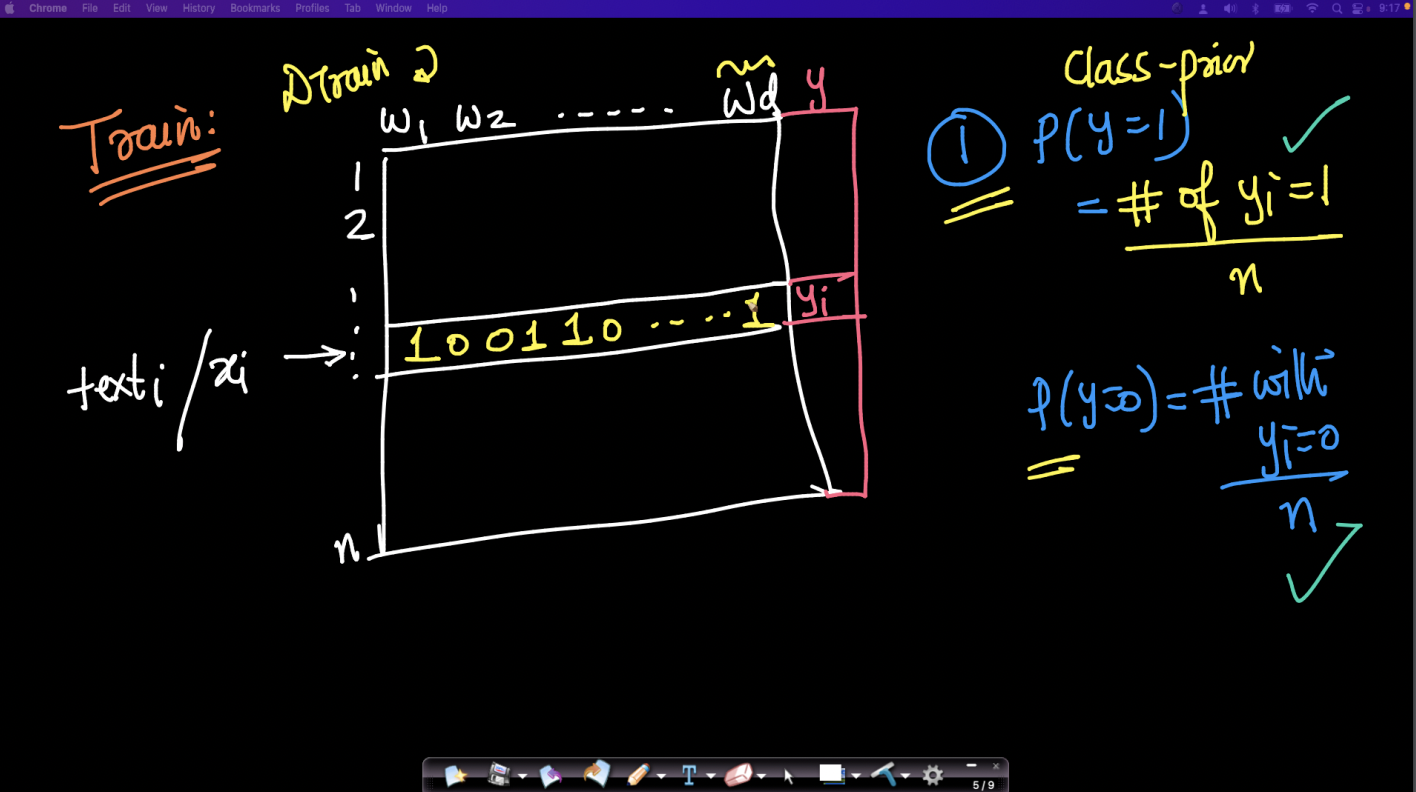

#### Q. How do we calculated the **likelihood** of **all words** (from 1 to d) for **both classes** (y=0 and y=1)?
These values are calculated using the **conditional probability** concept that you must've read about in the **pre-read**.

Lets consider $P(w_{j}|y_{i}=1)$ first,

- Thus, for a particular jth word $w_j$, we compute probabilty for all the datapoints where $y_i = 1$ and $w_j$ exists in that $text_i (x_i)$
- This is calculated as: $P(w_{j}|y_{i}=1) = \frac{P(w_{j} \cap y_{i}=1)}{P(y_{i}=1)} $
 
Similarily, the probability of occurence of word w<sub>j</sub> in a text with $y_i = 0$ (i.e. not spam) becomes $P(w_{j}|y_{i}=0) = \frac{P(w_{j} \cap y_{i}=0)}{P(y_{i}=0)} $

**NOTE:** Since there are d unique words, we get d such likelihood values for $y_i= 1$ (Spam) , and d different values for $y_i= 0$ (not Spam).

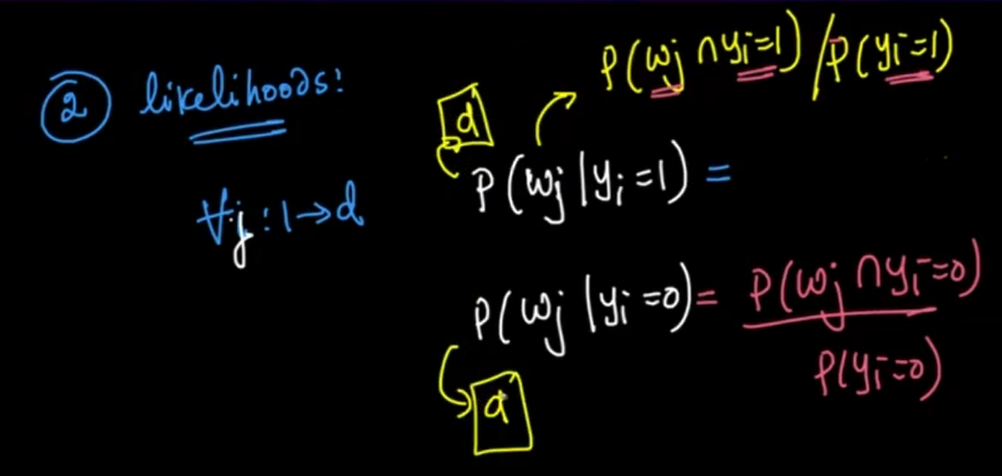

#### Q. How is Naive bayes getting trained here even though we do no weight updates?
We are computing d likelihoods for both classes along with class priors which is **analogous** to computing weights of the model.

#### Summarizing the things we have learnt from training Naive Bayes
- we will have two constants, both the class priors
 -   $P(y=1) = \frac{Number \ of \ samples \ with \ y_i=1}{Total \ number \ of \ samples}$
 -   $P(y=0) = \frac{Number \ of \ samples \ with \ y_i=0}{Total \ number \ of \ samples}$
- And d likelihood values for both classes
 - $P(w_{j}|y_{i}=1) = \frac{P(w_{j} \cap y_{i}=1)}{P(y_{i}=1)} $
 - $P(w_{j}|y_{i}=0) = \frac{P(w_{j} \cap y_{i}=0)}{P(y_{i}=0)} $

### What will be the **Training time complexity** of the Naive Bayes ?
Since we are to compute d likelihoods for all the n samples of the data
- the time complexity becomes **o(nd)**

# Test time of Naive Bayes

#### Q. Now that we have learnt about training dataset of Naive Bayes, what about the test dataset?
Suppose we have a query text  consists of the following words $text_{q} = w_{1}, w_{3}, w_{6}, w_{12}, w_{15}$

Note that, We have already calculated the class priors and the likelihoods of all words, for both classes in the training of our model.

<br>


#### Q. How will we predict $text_{q}$ belongs to $y_q=1 $ or $y_q=0$ ?
First, we need to calculate the probability of $y_q=1$ when words $w_{1}, w_{3}, w_{6}, w_{12}, w_{15}$ exist in the text.
- Recall this will be calculated as:
 - $P(y_q=1|w_{1}, w_{3}, w_{6}, w_{12}, w_{15}) ∝ 𝑃(𝑦=1)∗𝑃(𝑤_1|𝑦_𝑖=1)∗𝑃(𝑤_3|𝑦_𝑖=1)∗𝑃(𝑤_6|𝑦_𝑖=1)∗𝑃(𝑤_{12}|𝑦_𝑖=1)∗𝑃(𝑤_{15}|𝑦_𝑖=1)$

<br>

#### Q. Why are we using Propotionality sign while finding $P(y_q=1|w_{1}, w_{3}, w_{6}, w_{12}, w_{15})$ ?
Recall we defined $P(y=1|text_i)$ as  $\frac{P(y=1) * Π_{i=1}^d P(w_i|y_i=1)}{k}$ where k was $P(w_1,w_2...w_d)$ and how we discarded k from the equation since we are comparing $P(y=1|text_i)$ and $P(y=0|text_i)$ and k, a constant exist in both.

<br>

#### Q. How will we calculate the probability of $text_q$ being a spam or not?
We already have class prior and likelihood values calculated from training.

Notice how we only have 5 words in $text_q$ 

so the product of likelihoods can be clubbed from j=1 to k where k = 5.
 - $P(y_q=1|w_{1}, w_{3}, w_{6}, w_{12}, w_{15}) ∝ 𝑃(𝑦=1)∗ ∏_{j=1}^{k}  𝑃(𝑤_j|𝑦=1)$

Similarily, we can find the probability of $y_q=0$ when words $w_{1}, w_{3}, w_{6}, w_{12}, w_{15}$ exist in the text.

 - $P(y_q=0|w_{1}, w_{3}, w_{6}, w_{12}, w_{15}) ∝ 𝑃(𝑦=0)∗ ∏_{j=1}^{k}  𝑃(𝑤_j|𝑦=0)$


Now we compare the probability for both the classes and which ever one is higher, Naive bayes predicts that class as the $y_q$ for $x_q$

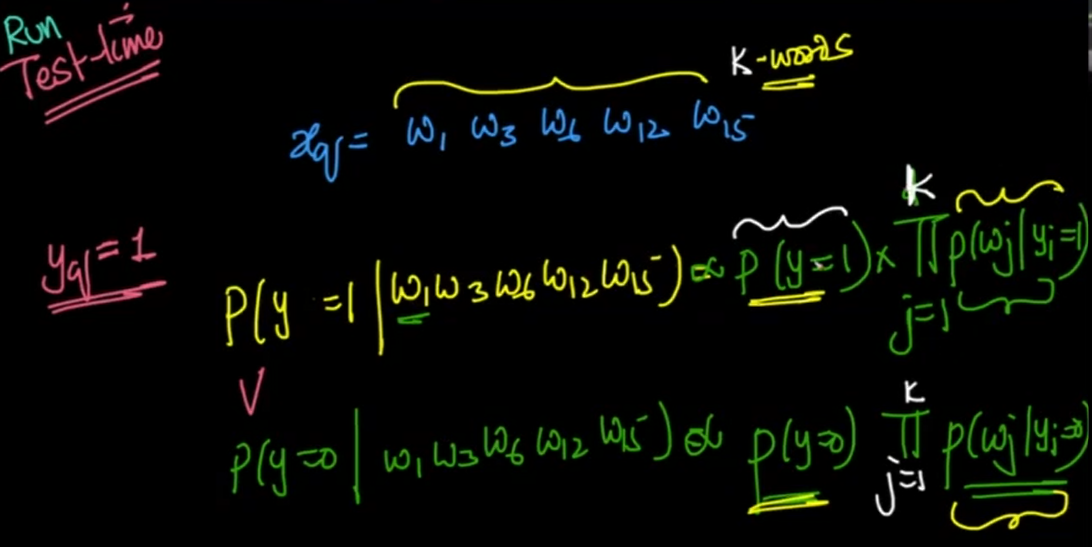

### Complexity of Naive Bayes



#### Q. based on both the training and test dataset of Naive Bayes, what will be the the space complexity at runtime ?
So, if you recall what we've studied, during training, we only need to store the values of **class priors** and the **likelihood** values for both classes.
- For class priors, we only have two values that need to be stored, P(y=0) and P(y=1)
- For likelihood, we get d values for $y_i=0$, and d values for $y_i=1$. Where d is the number of unique words that exist across all texts.
 - This means, we store d + d = 2d values for likelihood

This means, in total we store 2+2d values, so the space complexity becomes
 O(2d+2) = **O(d)**

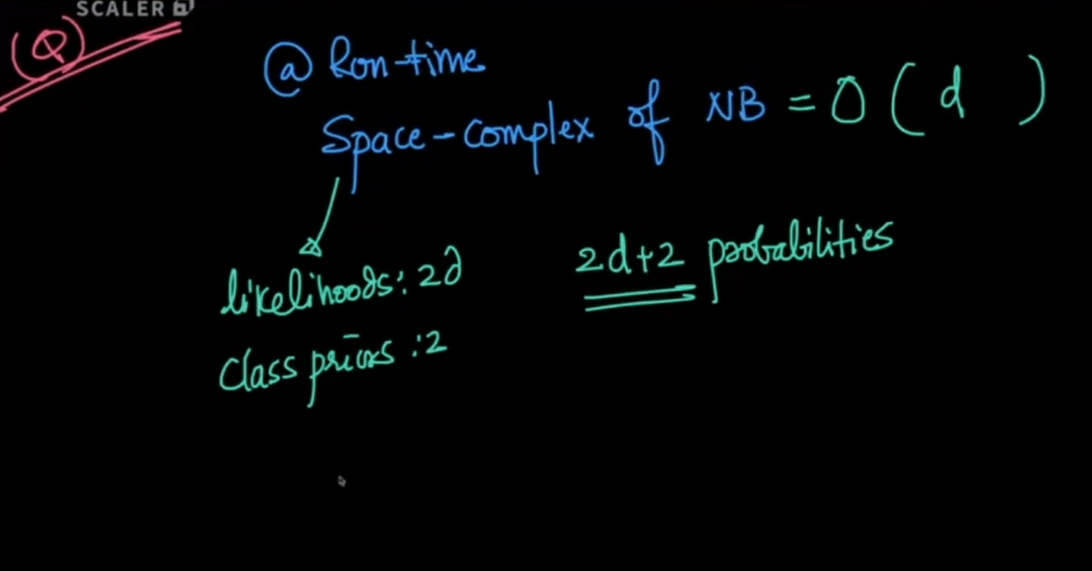


Now Suppose the $text_q$, contains k words.

####Q. What is the runtime complexity for predicting the class label for $text_q$? 
So, in order to compute the $P(y=1|w_{1}, w_{2}, ..., w_{k})$ and $P(y=0|w_{1}, w_{2}, ..., w_{k})$ values, we need the already calculated class prior values and the likelihood values for these k words.
 - Therefore, there will be 2 class prior values.
 - k values for $P(y=1|w_{1}, w_{2}, ..., w_{k})$
 - k values for $P(y=0|w_{1}, w_{2}, ..., w_{k})$

Therefore total values to compute the $P(y=1|w_{1}, w_{2}, ..., w_{k})$ and $P(y=0|w_{1}, w_{2}, ..., w_{k})$ becomes 2k+2, 

Meaning our complexity becomes: O(2k+2) = **O(k)**

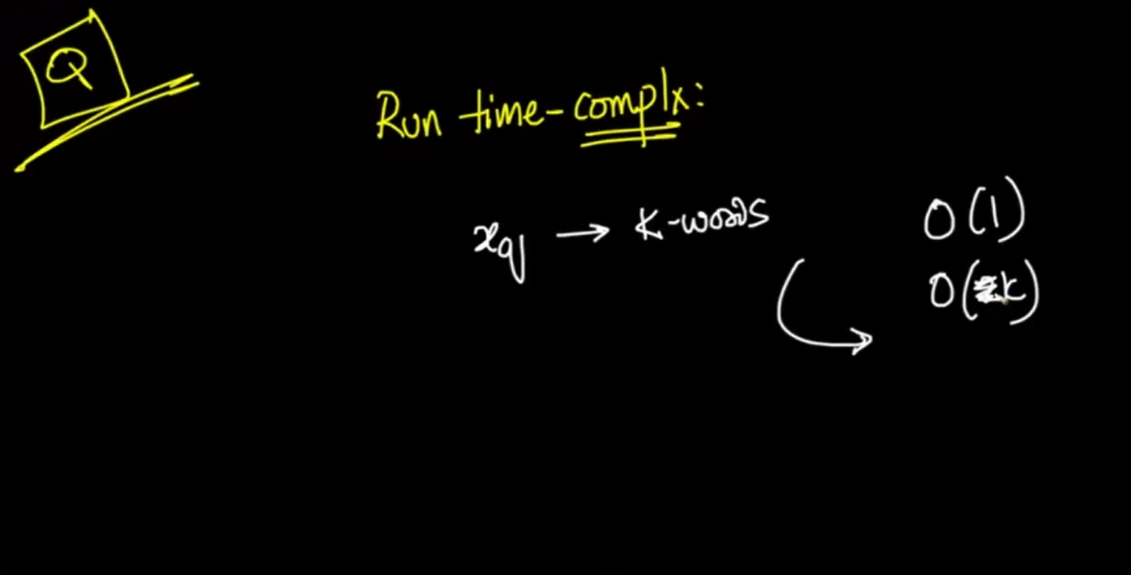